# Enrich administrative boundaries by population information

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
df = pd.read_csv('../data/New_York_City_Population_By_Neighborhood_Tabulation_Areas_20241223.csv')

In [3]:
gdf = gpd.read_file('../data/2010_nats.geojson')

In [4]:
print(len(df))
print(len(gdf))

390
195


In [5]:
df.head(1)

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,28149


In [6]:
gdf.head(1)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.7312,081,St. Albans,45401.3168869,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."


In [7]:
print(set(df.Year))

{2000, 2010}


In [8]:
df =df[df.Year == 2010]

In [9]:
len(df)

195

In [10]:
codes_1 = set(df['NTA Code'])
codes_2 = set(gdf['ntacode'])

In [11]:
len(codes_1), len(codes_2), len(codes_1.intersection(codes_2))

(195, 195, 195)

In [12]:
gdf_merged = gdf.merge(df, right_on = 'NTA Code', left_on = 'ntacode')
gdf_merged = gdf_merged[['ntacode', 'geometry', 'Population', 'boro_name', 'NTA Name']]
gdf_merged

,ntacode,geometry,Population,boro_name,NTA Name
0,QN08,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",48593,Queens,St. Albans
1,BK50,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",83693,Brooklyn,Canarsie
2,BX41,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",51807,Bronx,Mount Hope
3,QN38,"MULTIPOLYGON (((-73.7964 40.73828, -73.79639 4...",34034,Queens,Pomonok-Flushing Heights-Hillcrest
4,QN52,"MULTIPOLYGON (((-73.79493 40.7578, -73.79475 4...",26982,Queens,East Flushing
...,...,...,...,...,...
190,BX36,"MULTIPOLYGON (((-73.90487 40.85869, -73.90526 ...",54188,Bronx,University Heights-Morris Heights
191,QN01,"MULTIPOLYGON (((-73.77396 40.69981, -73.77446 ...",38894,Queens,South Jamaica
192,QN61,"MULTIPOLYGON (((-73.76845 40.70964, -73.76919 ...",53751,Queens,Jamaica
193,BK77,"MULTIPOLYGON (((-73.9014 40.69159, -73.90189 4...",57138,Brooklyn,Bushwick North


(-74.28337047814922, -73.67222994821337, 40.47516404814219, 40.93650271647436)

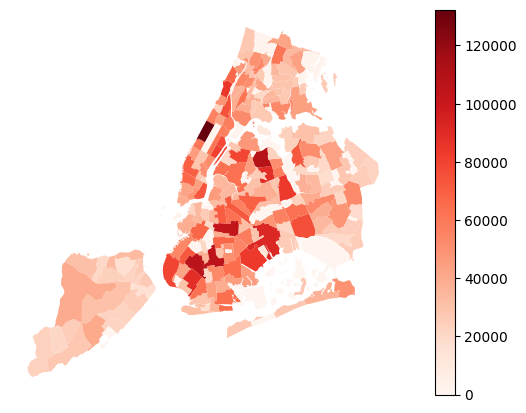

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize = (10, 5))

gdf_merged.plot(ax = ax,  column = 'Population', cmap = 'Reds', legend = True)

ax.axis('Off')

# Explore the administrative boundaries of the NYC neighbourhoods

In [14]:
gdf_manhattan = gdf_merged[gdf_merged.boro_name == 'Manhattan']
gdf_manhattan.head(2)

,ntacode,geometry,Population,boro_name,NTA Name
34,MN19,"MULTIPOLYGON (((-73.96052 40.74411, -73.96057 ...",51231,Manhattan,Turtle Bay-East Midtown
35,MN04,"MULTIPOLYGON (((-73.94035 40.83046, -73.94014 ...",48520,Manhattan,Hamilton Heights


In [15]:
gdf_manhattan_local = gdf_manhattan.to_crs(2263)
gdf_merged = gdf_merged.to_crs(2263)

<Axes: >

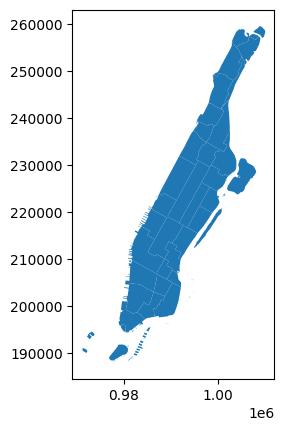

In [16]:
gdf_manhattan_local.plot()

In [17]:
distances = [100, 1000, 5000, 10000, 25000, 100000]

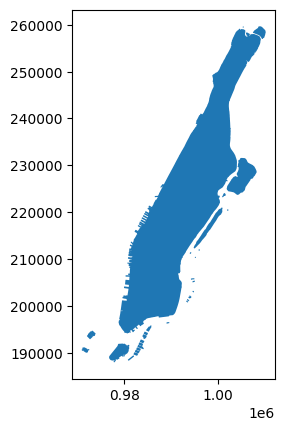

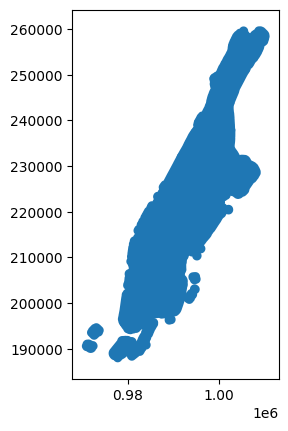

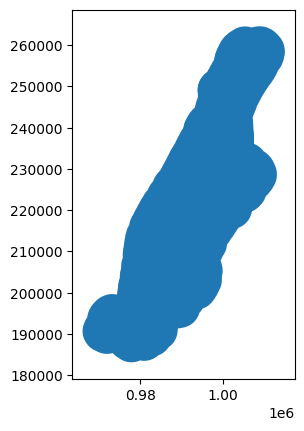

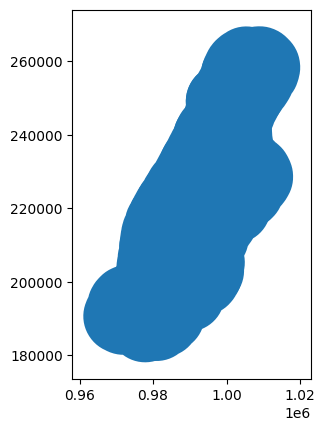

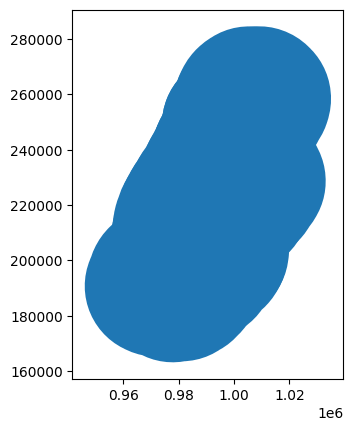

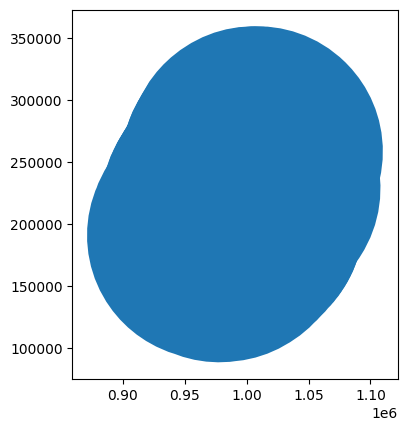

In [18]:
for distance in distances:
    gdf_manhattan_local.buffer(distance).plot()

<Axes: >

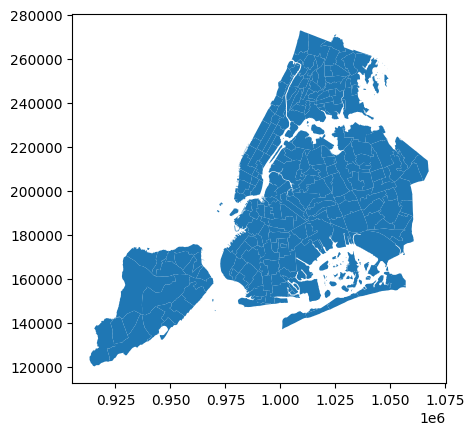

In [19]:
gdf_merged.plot()

In [20]:
gdf_merged_local_points = gdf_merged.copy()
gdf_merged_local_points['geometry'] = [g.centroid for g in list(gdf_merged_local_points.geometry)]
gdf_merged_local_points.head(3)

,ntacode,geometry,Population,boro_name,NTA Name
0,QN08,POINT (1049933.65 191188.479),48593,Queens,St. Albans
1,BK50,POINT (1012073.055 171748.235),83693,Brooklyn,Canarsie
2,BX41,POINT (1010498.971 248626.411),51807,Bronx,Mount Hope


<Axes: >

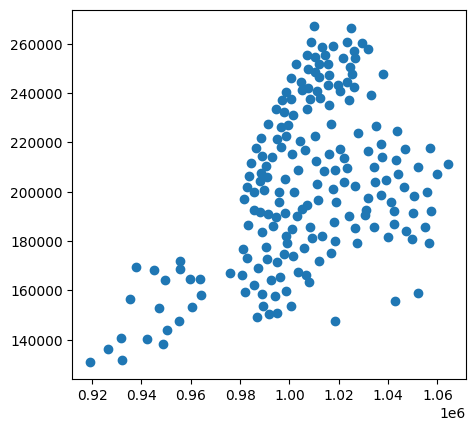

In [21]:
gdf_merged_local_points.plot()

<Axes: >

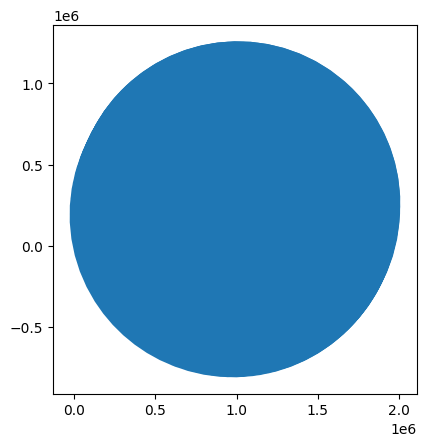

In [22]:
# buffering 
distance = 1000000
gdf_manhattan_local_buffered = gdf_manhattan_local.copy()
gdf_manhattan_local_buffered['geometry'] =gdf_manhattan_local_buffered['geometry'].buffer(distance)
gdf_manhattan_local_buffered.plot()

<Axes: >

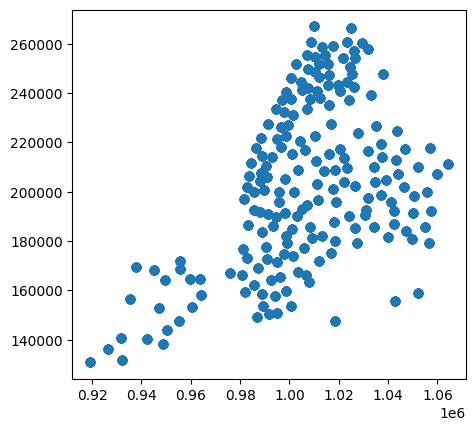

In [23]:
# spatial join 
gdf_joined = gpd.sjoin(gdf_merged_local_points, gdf_manhattan_local_buffered)
gdf_joined.plot()

In [24]:
# Compute population
print('Manhattan population: ', sum(gdf_joined.Population_left))
print('Buffer zone population: ', sum(gdf_joined.Population_right))
print('Buffer population ratio: ', sum(gdf_joined.Population_right) / sum(gdf_joined.Population_left))


Manhattan population:  237078857
Buffer zone population:  309245235
Buffer population ratio:  1.3043982028308834


# Urban greenery assesment

In [25]:
tdf = pd.read_csv('../data/2015_Street_Tree_Census_-_Tree_Data_20241223.csv', nrows = 10000)

In [26]:
tdf.head(3)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09


In [27]:
from shapely.geometry import Point

In [28]:
geometry = [Point(xy) for xy in zip(tdf['longitude'], tdf['latitude'])]

In [29]:
tdf = gpd.GeoDataFrame(tdf, geometry=geometry)

In [30]:
# Check if tdf is wrongly declared
print(tdf.head())  # Check if coordinates are in longitude/latitude
tdf = tdf.set_crs(epsg=4326)  # Set as WGS84
tdf = tdf.to_crs(epsg=2263)   # Reproject to EPSG:2263


   tree_id  block_id  created_at  tree_dbh  stump_diam curb_loc status health  \
0   180683    348711  08/27/2015         3           0   OnCurb  Alive   Fair   
1   200540    315986  09/03/2015        21           0   OnCurb  Alive   Fair   
2   204026    218365  09/05/2015         3           0   OnCurb  Alive   Good   
3   204337    217969  09/05/2015        10           0   OnCurb  Alive   Good   
4   189565    223043  08/30/2015        21           0   OnCurb  Alive   Good   

                            spc_latin       spc_common  ...     state  \
0                         Acer rubrum        red maple  ...  New York   
1                   Quercus palustris          pin oak  ...  New York   
2  Gleditsia triacanthos var. inermis      honeylocust  ...  New York   
3  Gleditsia triacanthos var. inermis      honeylocust  ...  New York   
4                     Tilia americana  American linden  ...  New York   

    latitude  longitude         x_sp         y_sp council district  \
0  4

In [31]:
gdf_join = gpd.sjoin(gdf_merged, tdf)

In [32]:
gdf_join = gdf_join[['NTA Name', 'Population', 'tree_id', 'geometry']]

In [33]:
gdf_join.head()

,NTA Name,Population,tree_id,geometry
0,St. Albans,48593,147003,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."
0,St. Albans,48593,146045,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."
0,St. Albans,48593,147009,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."
0,St. Albans,48593,166148,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."
0,St. Albans,48593,166149,"MULTIPOLYGON (((1052996.114 196307.361, 105308..."


In [43]:
# Group by 'Nta Name' and calculate the number of unique 'tree_id' values
gdf_grouped = gdf_join.groupby('NTA Name').agg({'tree_id': 'nunique'})

# Rename the resulting column for clarity
gdf_grouped = gdf_grouped.rename(columns={'tree_id': 'tree_count'})

gdf_grouped

,tree_count
NTA Name,
Allerton-Pelham Gardens,2
Annadale-Huguenot-Prince's Bay-Eltingville,100
Arden Heights,131
Astoria,184
Auburndale,13
...,...
Yorkville,90
park-cemetery-etc-Bronx,2
park-cemetery-etc-Brooklyn,34


In [44]:
gdf_join_tree = gdf_merged.merge(gdf_grouped, left_on = 'NTA Name', right_index=True)
gdf_join_tree.head(3)

,ntacode,geometry,Population,boro_name,NTA Name,tree_count
0,QN08,"MULTIPOLYGON (((1052996.114 196307.361, 105308...",48593,Queens,St. Albans,16
1,BK50,"MULTIPOLYGON (((1015236.113 174910.103, 101523...",83693,Brooklyn,Canarsie,13
2,BX41,"MULTIPOLYGON (((1013128.551 250637.755, 101284...",51807,Bronx,Mount Hope,126


In [46]:
gdf_join_tree['trees_per_capita'] = gdf_join_tree['tree_count'] / gdf_join_tree['Population']
gdf_join_tree = gdf_join_tree.sort_values(by = 'trees_per_capita', ascending = False)

In [47]:
gdf_join_tree.head(3)

,ntacode,geometry,Population,boro_name,NTA Name,tree_count,trees_per_capita
177,BK99,"MULTIPOLYGON (((1007822.043 152881.588, 100783...",418,Brooklyn,park-cemetery-etc-Brooklyn,34,0.081340
161,MN99,"MULTIPOLYGON (((981219.056 188655.316, 980940....",1849,Manhattan,park-cemetery-etc-Manhattan,33,0.017847
69,SI25,"MULTIPOLYGON (((950486.942 148843.707, 950434....",22049,Staten Island,Oakwood-Oakwood Beach,286,0.012971


In [49]:
gdf_join_tree[['NTA Name', 'tree_count', 'Population','trees_per_capita']].head(10)


,NTA Name,tree_count,Population,trees_per_capita
177,park-cemetery-etc-Brooklyn,34,418,0.081340
161,park-cemetery-etc-Manhattan,33,1849,0.017847
69,Oakwood-Oakwood Beach,286,22049,0.012971
62,Steinway,517,47534,0.010876
110,Kew Gardens,189,23278,0.008119
39,New Dorp-Midland Beach,155,21896,0.007079
46,Clinton Hill,202,34791,0.005806
149,Breezy Point-Belle Harbor-Rockwy Prk-Broad Chnl,153,28018,0.005461
73,Arden Heights,131,25238,0.005191
50,Ocean Parkway South,100,20299,0.004926


(905464.73902893, 1075092.878585814, 112492.57379449514, 280480.09020685364)

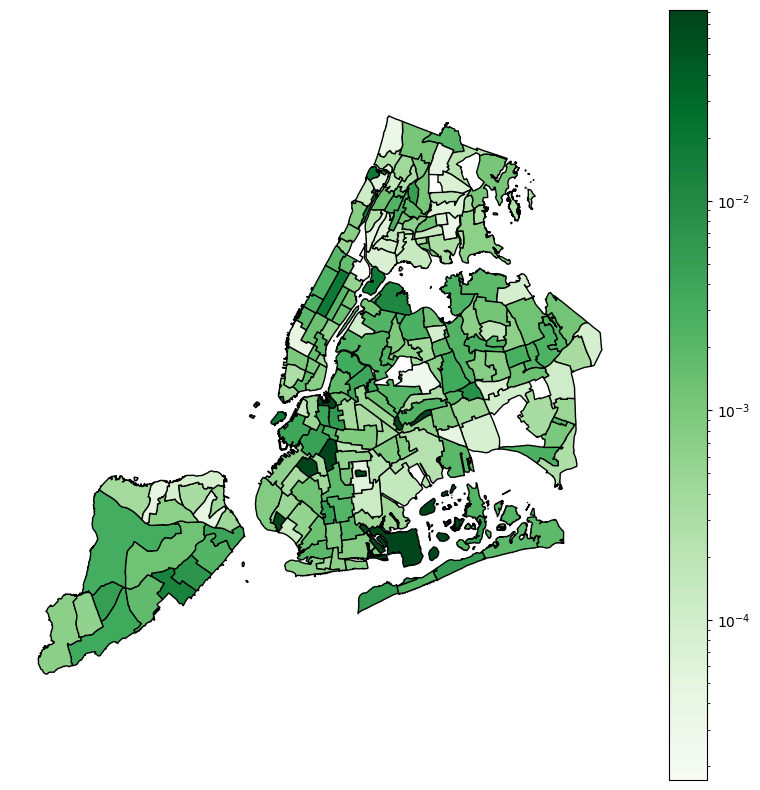

In [56]:
from matplotlib.colors import LogNorm

norm = LogNorm(vmin = gdf_join_tree['trees_per_capita'].min(),
               vmax = gdf_join_tree['trees_per_capita'].max())

f, ax = plt.subplots(1, 1, figsize = (10, 10))

gdf_join_tree.plot(ax=ax, column = 'trees_per_capita', 
                   cmap = "Greens", 
                   edgecolor = 'k',
                   norm = norm,
                   legend = True)

ax.axis('off')